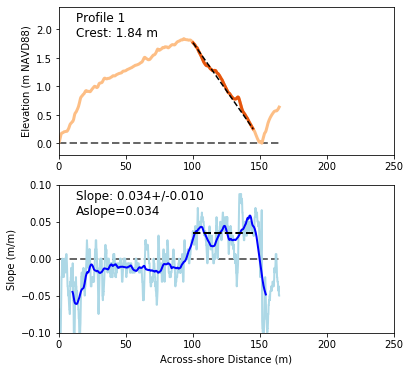

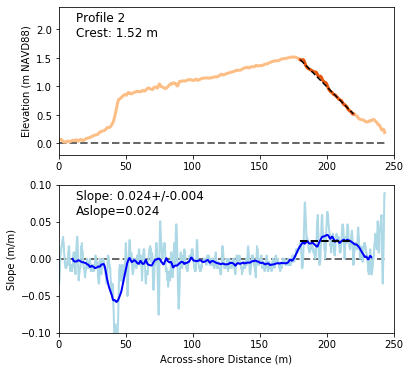

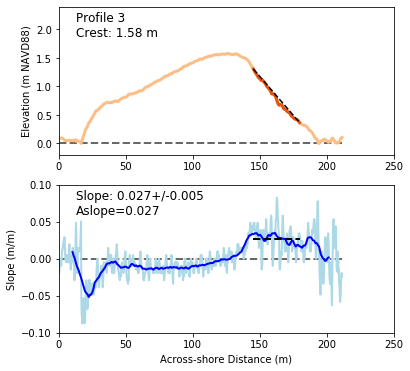

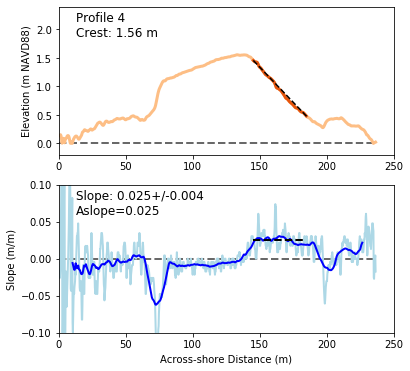

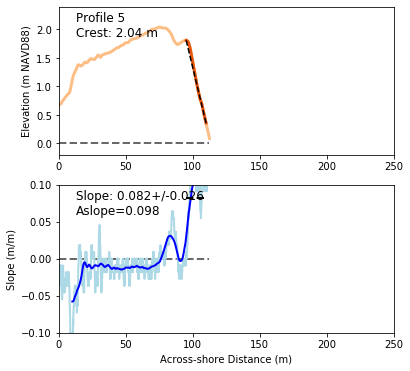

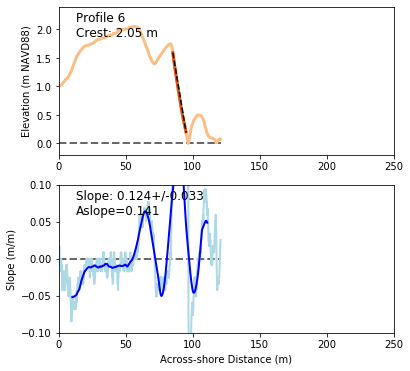

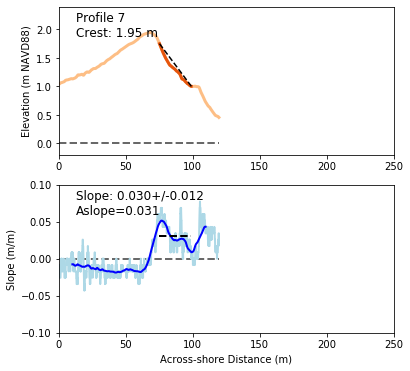

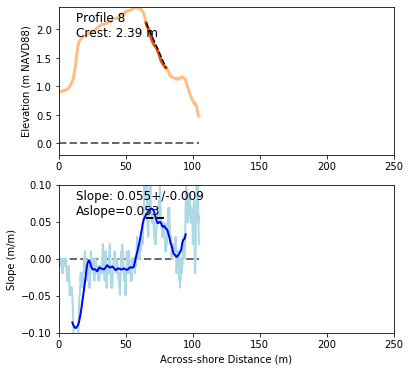

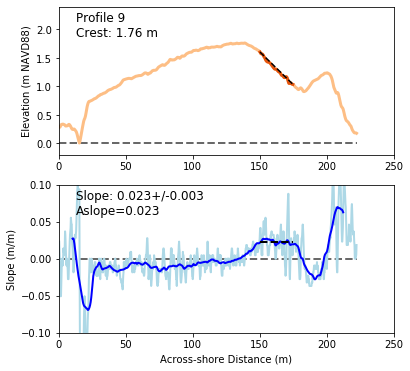

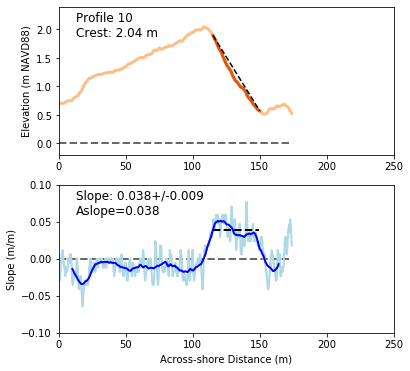

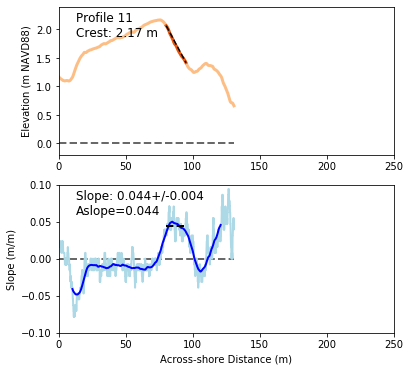

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
%matplotlib inline

cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']

# these are the start/stop distances for the beach face - hand picked
dstart = [100,180,145,145, 95,85,75,65,150,115,80]
dend   = [145,220,180,185,110,95,99,80,175,150,95]

# arrays for results [crest, aslope, slope_mean, slope_std]
r = np.empty((11,4))

for i in range(1,12):
    fname = './2020-11-26_berm_profiles/p{:0d}.csv'.format(i)

    # The .csv profile files written by Global Mapper have some weird characters we want to get rid of.
    # Read in the file
    with open(fname, 'r') as f :
      filedata = f.read()

    # Replace the target strings
    filedata = filedata.replace('%', '')
    filedata = filedata.replace('-', '')

    # Write the file out again
    with open(fname, 'w') as f:
      f.write(filedata)

    # read the profile
    df=pd.read_csv(fname,header = 0,delimiter=',')

    # extract a few columns with convenient names
    dist = df['Distance (Total)'].values
    elev = df['Elevation'].values
    crest_el = np.max(elev)
    slope_deg = df['Slope (Degrees)']
    dx = df['Distance (Segment)'].values[1]
    slope = np.nan*np.ones_like(dist)
    slope[1:]=np.diff(elev)/dx

    # Want to smooth over about N meters...how many points is that for the filter window?
    nmeters = 20.
    npts = int(nmeters/dx)
    # npts must be odd
    if (npts % 2) == 0:
        npts = npts+1

    # smooth with Savitsky-Golay filter
    sslope = savgol_filter(slope, npts, 3, mode='constant',cval=np.nan) # window size npts, polynomial order 3
    
    # find indices corresponding to start/stop distances
    istart = int(np.argwhere(dist>=dstart[i-1])[0])
    iend   = int(np.argwhere(dist<=dend[i-1])[-1])

    dsamp = dist[istart:iend]
    esamp = elev[istart:iend]
    ssamp = sslope[istart:iend]
    aslope = (elev[istart]-elev[iend])/(dist[iend]-dist[istart])
    slope_m = np.nanmean(-ssamp)
    slope_sd = np.nanstd(-ssamp)
    
    r[i-1,:] = [crest_el, aslope, slope_m, slope_sd]

    plt.figure(figsize=(6,6))
    ax1=plt.subplot(211)
    plt.plot(dist,np.ones_like(dist)*0.,'--',c='dimgray',linewidth=2)
    plt.plot(dist,elev,c=cols[1],linewidth=3,label='Elevation (m)')
    plt.plot([dist[istart],dist[iend]],[elev[istart],elev[iend]],'--k',zorder=4)
    plt.plot(dsamp,esamp,c=cols[3],linewidth=3)

    plt.xlim(0,250)
    plt.ylim(-.2,2.4)
    ts = 'Profile {:0d}\nCrest: {:.2f} m'.format(i,crest_el)
    ax1.text(0.05,.8, ts, fontsize=12, transform=ax1.transAxes)
    plt.ylabel('Elevation (m NAVD88)')

    ax2=plt.subplot(212)
    plt.plot(dist,np.ones_like(dist)*0.,'--',c='dimgray',linewidth=2)
    plt.plot(dist,-slope,linewidth=2,c='lightblue',label='Slope (m/m)')
    plt.plot(dist,-sslope,linewidth=2,c='blue',label='Smoothed slope (m/m)')
    plt.plot(dsamp,slope_m*np.ones_like(dsamp),'--',linewidth=2,c='black',label='Mean slope (m/m)',zorder=6)
    plt.xlim(0,250)
    plt.ylim(-.1,.1)
    #plt.legend()
    ts = 'Slope: {:.3f}+/-{:.3f}\nAslope={:.3f}'.format(slope_m,slope_sd,aslope)
    ax2.text(0.05,.8, ts, fontsize=12, transform=ax2.transAxes)
    plt.ylabel('Slope (m/m)')
    plt.xlabel('Across-shore Distance (m)')

    pltname = 'p{:0d}.png'.format(i)
    plt.savefig(pltname,bbox='tight')

In [2]:
dfr = pd.DataFrame(r,columns=['crest','aslope','slope mean','slope_std'])
dfr.describe()

,crest,aslope,slope mean,slope_std
count,11.000000,11.000000,11.000000,11.000000
mean,1.899000,0.048902,0.046094,0.010857
std,0.276332,0.037411,0.031290,0.009863
min,1.517000,0.023012,0.022940,0.002706
25%,1.671000,0.025928,0.025985,0.003970
50%,1.946000,0.033668,0.034335,0.008826
75%,2.047500,0.048515,0.049622,0.011236
max,2.386000,0.141401,0.124448,0.033101
